## Title Cell

In [ ]:
# Import dependencies
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import csv, convert to a dataframe. List the columns so we know how to clean it up
diabetes_csv = pd.read_csv("source_data/diabetes_indicators.csv")
diabetes_df = pd.DataFrame(diabetes_csv)
diabetes_df.columns

## William

In [ ]:
# Define colors
colors = ['#CACACA','#78909C','#616161']

# Trim the dataframe so it is only our variables of interest
df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()
df_trimmed.head()

In [ ]:
# Group by fruit consumption and diabetes status, count the number of participants for each category
dia_fruits = df_trimmed.groupby(["Fruits", "Diabetes_012"]).size().reset_index(name='count')

# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
nofruits = dia_fruits[dia_fruits["Fruits"] == 0].copy()
yesfruits = dia_fruits[dia_fruits["Fruits"] == 1].copy()

# Find the total respondents per category (fruit and no fruit)
# Create a new column for the proportion of respondents in each row out of their respective category
nofruits_sum = nofruits["count"].sum()
nofruits["proportion"] = (nofruits["count"] / nofruits_sum) * 100

yesfruits_sum = yesfruits["count"].sum()
yesfruits["proportion"] = (yesfruits["count"] / yesfruits_sum) * 100

# Using the pd.concat() function, combine the two tables into the new fruitstack df, which shows the proportions
fruitstack = pd.concat([nofruits, yesfruits], ignore_index=False)
fruitstack




In [ ]:
# Set up pivot table to reorganize fruitstack df
fruit_pivot_df = fruitstack.pivot(index='Fruits', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
fruit_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']


# Rename indices for easy display formatting
index_mapping = {0.0: 'Consume fruit less than once per day', 1.0: 'Consume fruit once or more per day'}
fruit_pivot_df.index = fruit_pivot_df.index.map(index_mapping)

# Plot the table
fruit_pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportion of Respondents with Diabetes\n(Non-fruit consumers vs. fruit consumers)')
plt.xlabel('Fruits')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(fruit_pivot_df.index)), labels=fruit_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/fruit_vs_diabetes.png")
plt.show()

In [ ]:
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(fruit_pivot_df)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The two samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The two samples are therefore statistically different.")

In [ ]:
# Group by veg consumption and diabetes status, count the number of participants for each category
dia_veg = df_trimmed.groupby(["Veggies", "Diabetes_012"]).size().reset_index(name='count')

# Separate 0 veg values from 1 veg values, copying the tables so we can easily perform actions on them
noveg = dia_veg[dia_veg["Veggies"] == 0].copy()
yesveg = dia_veg[dia_veg["Veggies"] == 1].copy()

# Find the total respondents per category (veg and no veg)
# Create a new column for the proportion of respondents in each row out of their respective category
noveg_sum = noveg["count"].sum()
noveg["proportion"] = (noveg["count"] / noveg_sum) * 100

yesveg_sum = yesveg["count"].sum()
yesveg["proportion"] = (yesveg["count"] / yesveg_sum) * 100

# Using the pd.concat() function, combine the two tables into the new vegstack df, which shows the proportions
vegstack = pd.concat([noveg, yesveg], ignore_index=False)

# Pivot the table
veg_pivot_df = vegstack.pivot(index='Veggies', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
veg_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {0.0: 'Consume vegetables less than once per day', 1.0: 'Consume vegetables once or more per day'}
veg_pivot_df.index = veg_pivot_df.index.map(index_mapping)

# Plot the table
veg_pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportion of Respondents with Diabetes\n(Non-vegetable consumers vs. vegetable consumers)')
plt.xlabel('Vegetables')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(veg_pivot_df.index)), labels=veg_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/veg_vs_diabetes.png")
plt.show()

In [ ]:
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(veg_pivot_df)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The two samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The two samples are therefore statistically different.")

In [ ]:
# Group by income and diabetes, count the number of responses in each row
dia_income = df_trimmed.groupby(["Income", "Diabetes_012"]).size().reset_index(name='count')

# Calculate the sum of responses for each income group
income_group_sum = dia_income.groupby('Income')['count'].transform('sum')

# Calculate the proportions
dia_income['proportion'] = (dia_income['count'] / income_group_sum) * 100

# Pivot the table
income_pivot_df = dia_income.pivot(index='Income', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
income_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }
income_pivot_df.index = income_pivot_df.index.map(index_mapping)

# Plot the table
ax = income_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Percentage of Respondents with Diabetes by Income')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(income_pivot_df.index)), labels=income_pivot_df.index, rotation=45)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/income_vs_diabetes.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all income categories
chi2, p, dof, expected = stats.chi2_contingency(income_pivot_df)

# Output the results
print(f"For all income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest income categories (the greatest difference in proportions)
income_highlow = income_pivot_df.loc[["Less than \$10k", "More than \$75k"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(income_highlow)

# Output the results
print(f"Between highest and lowest incomes:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

In [ ]:
# Group by education and diabetes, count the number of responses in each row
dia_edu = df_trimmed.groupby(["Education", "Diabetes_012"]).size().reset_index(name='count')

# Calculate the sum of responses for each education group
education_group_sum = dia_edu.groupby('Education')['count'].transform('sum')

# Calculate the proportions
dia_edu['proportion'] = (dia_edu['count'] / education_group_sum) * 100

# Pivot the table
edu_pivot_df = dia_edu.pivot(index='Education', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
edu_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }
edu_pivot_df.index = edu_pivot_df.index.map(index_mapping)

# Plot the table
ax = edu_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Percentage of Respondents with Diabetes by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(edu_pivot_df.index)), labels=edu_pivot_df.index, rotation=45)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/education_vs_diabetes.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all education categories
chi2, p, dof, expected = stats.chi2_contingency(edu_pivot_df)

# Output the results
print(f"For all education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
edu_highlow = edu_pivot_df.loc[["No schooling", "College, 4+ years"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(edu_highlow)

# Output the results
print(f"Between highest and lowest education:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

In [ ]:
# Group by age and diabetes, count the number of responses in each row
dia_age = df_trimmed.groupby(["Age", "Diabetes_012"]).size().reset_index(name='count')

# Calculate the sum of responses for each age group
age_group_sum = dia_age.groupby('Age')['count'].transform('sum')

# Calculate the proportions
dia_age['proportion'] = (dia_age['count'] / age_group_sum) * 100

# Pivot the table
age_pivot_df = dia_age.pivot(index='Age', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
age_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }
age_pivot_df.index = age_pivot_df.index.map(index_mapping)

# Plot the table
ax = age_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Percentage of Respondents with Diabetes by Age')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(age_pivot_df.index)), labels=age_pivot_df.index, rotation=45)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/age_vs_diabetes.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all age categories
chi2, p, dof, expected = stats.chi2_contingency(age_pivot_df)

# Output the results
print(f"For all age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
age_highlow = age_pivot_df.loc[["18 to 24", "80 or older"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(age_highlow)

# Output the results
print(f"Between highest and lowest age groups:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

In [ ]:
# Group by income and fruits, count the number of responses in each row
income_fruit = df_trimmed.groupby(['Income', 'Fruits']).size().reset_index(name='count')

# Calculate the sum of responses for each income group
incfruit_group_sum = income_fruit.groupby('Income')['count'].transform('sum')

# Calculate the proportions
income_fruit['proportion'] = (income_fruit['count'] / incfruit_group_sum) * 100

# Pivot the table
incfruit_pivot_df = income_fruit.pivot(index='Income', columns='Fruits', values='proportion')

# Rename columns for easy display formatting
incfruit_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }

incfruit_pivot_df.index = incfruit_pivot_df.index.map(index_mapping)

# Plot the table
ax = incfruit_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Fruit Consumption by Income Group')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(incfruit_pivot_df.index)), labels=incfruit_pivot_df.index, rotation=45)
plt.legend(title='Fruit Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/income_vs_fruit.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all income categories
chi2, p, dof, expected = stats.chi2_contingency(incfruit_pivot_df)

# Output the results
print(f"For all income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest income categories (the greatest difference in proportions)
incfruit_highlow = incfruit_pivot_df.loc[["Less than \$10k", "More than \$75k"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(incfruit_highlow)

# Output the results
print(f"For highest and lowest income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

In [ ]:
# Group by income and veggies, count the number of responses in each row
income_veg = df_trimmed.groupby(['Income', 'Veggies']).size().reset_index(name='count')

# Calculate the sum of responses for each income group
incveg_group_sum = income_veg.groupby('Income')['count'].transform('sum')

# Calculate the proportions
income_veg['proportion'] = (income_veg['count'] / incveg_group_sum) * 100

# Pivot the table
incveg_pivot_df = income_veg.pivot(index='Income', columns='Veggies', values='proportion')

# Rename columns for easy display formatting
incveg_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }

incveg_pivot_df.index = incveg_pivot_df.index.map(index_mapping)

# Plot the table
ax = incveg_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Vegetable Consumption by Income Group')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(incveg_pivot_df.index)), labels=incveg_pivot_df.index, rotation=45)
plt.legend(title='Vegetable Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/income_vs_veg.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all income categories
chi2, p, dof, expected = stats.chi2_contingency(incveg_pivot_df)

# Output the results
print(f"For all income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest income categories (the greatest difference in proportions)
incveg_highlow = incveg_pivot_df.loc[["Less than \$10k", "More than \$75k"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(incveg_highlow)

# Output the results
print(f"For highest and lowest income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

In [ ]:
# Group by education and fruits, count the number of responses in each row
edu_fruit = df_trimmed.groupby(['Education', 'Fruits']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
edufruit_group_sum = edu_fruit.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_fruit['proportion'] = (edu_fruit['count'] / edufruit_group_sum) * 100

# Pivot the table
edufruit_pivot_df = edu_fruit.pivot(index='Education', columns='Fruits', values='proportion')

# Rename columns for easy display formatting
edufruit_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

edufruit_pivot_df.index = edufruit_pivot_df.index.map(index_mapping)

# Plot the table
ax = edufruit_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Fruit Consumption by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(edufruit_pivot_df.index)), labels=edufruit_pivot_df.index, rotation=45)
plt.legend(title='Fruit Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/education_vs_fruit.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all education categories
chi2, p, dof, expected = stats.chi2_contingency(edufruit_pivot_df)

# Output the results
print(f"For all education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
edufruit_highlow = edufruit_pivot_df.loc[["Grades 9 through 11", "College, 4+ years"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(edufruit_highlow)

# Output the results
print(f"For the highest and lowest education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

In [ ]:
# Group by education and veggies, count the number of responses in each row
edu_veg = df_trimmed.groupby(['Education', 'Veggies']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
eduveg_group_sum = edu_veg.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_veg['proportion'] = (edu_veg['count'] / eduveg_group_sum) * 100

# Pivot the table
eduveg_pivot_df = edu_veg.pivot(index='Education', columns='Veggies', values='proportion')

# Rename columns for easy display formatting
eduveg_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

eduveg_pivot_df.index = eduveg_pivot_df.index.map(index_mapping)

# Plot the table
ax = eduveg_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Vegetable Consumption by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(eduveg_pivot_df.index)), labels=eduveg_pivot_df.index, rotation=45)
plt.legend(title='Vegetable Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/education_vs_veg.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all education categories
chi2, p, dof, expected = stats.chi2_contingency(eduveg_pivot_df)

# Output the results
print(f"For all education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
eduveg_highlow = eduveg_pivot_df.loc[["Grades 9 through 11", "College, 4+ years"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(eduveg_highlow)

# Output the results
print(f"Between the highest and lowest education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

In [ ]:
# Group by age and fruits, count the number of responses in each row
age_fruit = df_trimmed.groupby(['Age', 'Fruits']).size().reset_index(name='count')

# Calculate the sum of responses for each age group
agefruit_group_sum = age_fruit.groupby('Age')['count'].transform('sum')

# Calculate the proportions
age_fruit['proportion'] = (age_fruit['count'] / agefruit_group_sum) * 100

# Pivot the table
agefruit_pivot_df = age_fruit.pivot(index='Age', columns='Fruits', values='proportion')

# Rename columns for easy display formatting
agefruit_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

agefruit_pivot_df.index = agefruit_pivot_df.index.map(index_mapping)

# Plot the table
ax = agefruit_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Fruit Consumption by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(agefruit_pivot_df.index)), labels=agefruit_pivot_df.index, rotation=45)
plt.legend(title='Fruit Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/age_vs_fruit.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all age categories
chi2, p, dof, expected = stats.chi2_contingency(agefruit_pivot_df)

# Output the results
print(f"For all age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest age categories (the greatest difference in proportions)
agefruit_highlow = agefruit_pivot_df.loc[["18 to 24", "80 or older"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(agefruit_highlow)

# Output the results
print(f"For highest and lowest age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

In [ ]:
# Group by age and fruits, count the number of responses in each row
age_veg = df_trimmed.groupby(['Age', 'Veggies']).size().reset_index(name='count')

# Calculate the sum of responses for each age group
ageveg_group_sum = age_veg.groupby('Age')['count'].transform('sum')

# Calculate the proportions
age_veg['proportion'] = (age_veg['count'] / ageveg_group_sum) * 100

# Pivot the table
ageveg_pivot_df = age_veg.pivot(index='Age', columns='Veggies', values='proportion')

# Rename columns for easy display formatting
ageveg_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

ageveg_pivot_df.index = ageveg_pivot_df.index.map(index_mapping)

# Plot the table
ax = ageveg_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Vegetable Consumption by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(ageveg_pivot_df.index)), labels=ageveg_pivot_df.index, rotation=45)
plt.legend(title='Vegetable Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/age_vs_veg.png")
plt.show()

In [ ]:
# Run the Chi-squared test for all age categories
chi2, p, dof, expected = stats.chi2_contingency(ageveg_pivot_df)

# Output the results
print(f"For all age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
ageveg_highlow = agefruit_pivot_df.loc[["18 to 24", "80 or older"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(agefruit_highlow)

# Output the results
print(f"For highest and lowest age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-sauqred test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

## Chinna

In [ ]:
# Group by PhysActivity and diabetes status, count the number of participants for each category
dia_PhysActivity = df_trimmed.groupby(["PhysActivity", "Diabetes_012"]).size().reset_index(name='count')


# Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
no_PhysActivity = dia_PhysActivity[dia_PhysActivity["PhysActivity"] == 0].copy()
yes_PhysActivity = dia_PhysActivity[dia_PhysActivity["PhysActivity"] == 1].copy()

# Find the total respondents per category (PhysActivity and no PhysActivity)
# Create a new column for the proportion of respondents in each row out of their respective category
no_PhysActivity_sum = no_PhysActivity["count"].sum()
no_PhysActivity["proportion"] = (no_PhysActivity["count"] / no_PhysActivity_sum) * 100

yes_PhysActivity_sum = yes_PhysActivity["count"].sum()
yes_PhysActivity["proportion"] = (yes_PhysActivity["count"] / yes_PhysActivity_sum) * 100

# Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
PhysActivitystack = pd.concat([no_PhysActivity, yes_PhysActivity], ignore_index=False)
PhysActivitystack

In [ ]:
# Set up pivot table to reorganize PhysActivity df
PhysActivity_pivot_df = PhysActivitystack.pivot(index='PhysActivity', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
PhysActivity_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {0.0: 'No exercise during the last month', 1.0: 'Exercise during the last month'}
PhysActivity_pivot_df.index = PhysActivity_pivot_df.index.map(index_mapping)

# Plot the table
colors = ['#CACACA','#78909C','#616161']
PhysActivity_pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportion of Respondents with Diabetes\n(Non-PhysActivity vs. PhysActivity)')
plt.xlabel('PhysActivity')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(PhysActivity_pivot_df.index)), labels=PhysActivity_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:

# PhysActivity Pie Chart

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# Define colors
colors = ['#CACACA','#78909C','#616161']

for i, column in enumerate(PhysActivity_pivot_df.columns):
    wedges, texts, autotexts = axes[i].pie(
        PhysActivity_pivot_df[column],
        labels=PhysActivity_pivot_df.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors[:len(PhysActivity_pivot_df.index)]  # Adjust colors to match number of slices
    )
    axes[i].set_title(column, fontsize=16, color='black')  # Title font size and color

    # Adjust font size and color for pie chart labels and percentages
    for text in texts:
        text.set_fontsize(10)
        text.set_color('black')  # Set color of pie chart labels
    for autotext in autotexts:
        autotext.set_fontsize(14)
        autotext.set_color('white')  # Set color of percentages

plt.suptitle('Proportion of Respondents with Diabetes by Physical Activity Status', fontsize=18)


plt.tight_layout()
plt.savefig("images/dia_vs_physactivity.png")
plt.show()


In [ ]:
#stacked bar chart PhysActivity

#stacked bar chart PhysActivity
data = {
    'No Diabetes': [20, 30],
    'Prediabetes': [15, 25],
    'Diabetes': [10, 20]
}
PhysActivity_pivot_df = pd.DataFrame(data, index=['No exercise during the last month', 'Exercise during the last month'])

# Define colors for each segment
colors = ['#CACACA','#78909C','#616161']

# Plotting the stacked bar chart
ax = PhysActivity_pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Customize the chart
plt.title('Proportion of Respondents with Diabetes by PhysActivity Status')
plt.xlabel('PhysActivity')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(PhysActivity_pivot_df.index)), labels=PhysActivity_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13', fontsize='11')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/dia_vs_physactivity_pie.png")
# Show the plot
plt.show()

In [ ]:
#Doughnut Chart 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['#CACACA','#78909C','#616161']
for i, column in enumerate(PhysActivity_pivot_df.columns):
    wedges, texts, autotexts = axes[i].pie(PhysActivity_pivot_df[column], labels=PhysActivity_pivot_df.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4), colors=colors)
    axes[i].set_title(column)

plt.suptitle('Proportion of Respondents with Diabetes by Physical Activity Status')
plt.tight_layout()
plt.savefig("images/dia_vs_physactivity_bar.png")
plt.show()

In [ ]:
#Chi square solution PhysActivity

# Example data for demonstration
data = {
    'PhysActivity': ['No exercise during the last month', 'Exercise during the last month'],
    'No Diabetes': [50, 30],
    'Prediabetes': [20, 15],
    'Diabetes': [10, 25]
}

PhysActivitystack = pd.DataFrame(data)
PhysActivitystack.set_index('PhysActivity', inplace=True)


from scipy.stats import chi2_contingency

# Prepare contingency table for Chi-Square test
contingency_table01 = PhysActivitystack.T  # Transpose to get counts in columns

contingency_table01



In [ ]:
# Perform Chi-Square test
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table01)

# Output the results
print(f'Chi-Square Statistic: {chi2_stat}')
print(f'P-Value: {p_val}')
print(f'Degrees of Freedom: {dof}')
print('Expected Frequencies:')
print(ex)
if p_val > 0.05:
    print(f"The p-value of the chi-squared test is {round(p_val,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The two samples are therefore not statistically different.")
else:
        print(f"The p-value of the chi-squared test is {round(p_val,4)}. As this value is less than 0.05, we reject the null hypothesis. The two samples are therefore statistically different.")

In [ ]:
#Fixed Chi-Square test/ updated percentage to correct count value.


# Create a contingency table
contingency_table02 = pd.crosstab(df_trimmed['Diabetes_012'], df_trimmed['PhysActivity'])

#Rename Column and Row Labels:
contingency_table02.columns = ['No exercise during the last month', 'Exercise during the last month']
contingency_table02.index = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table01)

# Print results
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

# Interpretation of results

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Diabetes Status.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Diabetes Status.")

contingency_table02



In [ ]:
#PhysActivity to Income
# Group by PhysActivity and Income, count the number of participants for each category
dia_PhysActivity_Income = df_trimmed.groupby(["PhysActivity", "Income"]).size().reset_index(name='count')


# Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
no_PhysActivity_Income = dia_PhysActivity_Income[dia_PhysActivity_Income["PhysActivity"] == 0].copy()
yes_PhysActivity_Income = dia_PhysActivity_Income[dia_PhysActivity_Income["PhysActivity"] == 1].copy()

# Find the total respondents per category (PhysActivity and no PhysActivity)
# Create a new column for the proportion of respondents in each row out of their respective category
no_PhysActivity_sum_Income = no_PhysActivity_Income["count"].sum()
no_PhysActivity_Income["proportion"] = (no_PhysActivity_Income["count"] / no_PhysActivity_sum_Income) * 100

yes_PhysActivity_sum_Income = yes_PhysActivity_Income["count"].sum()
yes_PhysActivity_Income["proportion"] = (yes_PhysActivity_Income["count"] / yes_PhysActivity_sum_Income) * 100

# Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
PhysActivitystack_Income = pd.concat([no_PhysActivity_Income, yes_PhysActivity_Income], ignore_index=False)
PhysActivitystack_Income





In [ ]:
PhysActivity_pivot_Income = PhysActivitystack_Income.pivot(index='Income', columns='PhysActivity', values='proportion')
colors = ['#CACACA','#78909C','#616161']
# Rename columns for clarity
PhysActivity_pivot_Income.columns = ['No Physical Activity', 'Physical Activity']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
PhysActivity_pivot_Income.plot(kind='bar', ax=ax, color=['#CACACA', '#78909c'])

# Formatting
plt.title('Proportion of Respondents by Income Level and Physical Activity Status')
plt.xlabel('Income Level')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['Less than \$10k', '\$10k to \$15k', '\$15k to \$20k', '\$20k to \$25k', '\$25k to \$35k', '\$35k to \$50k', '\$50k to \$75k', 'More than \$75k'], rotation=45)
plt.legend(title='Physical Activity Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
#PhysActivity to Age
# Group by PhysActivity and Age, count the number of participants for each category
dia_PhysActivity_Age = df_trimmed.groupby(["PhysActivity", "Age"]).size().reset_index(name='count')


# Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
no_PhysActivity_Age = dia_PhysActivity_Age[dia_PhysActivity_Age["PhysActivity"] == 0].copy()
yes_PhysActivity_Age = dia_PhysActivity_Age[dia_PhysActivity_Age["PhysActivity"] == 1].copy()

# Find the total respondents per category (PhysActivity and no PhysActivity)
# Create a new column for the proportion of respondents in each row out of their respective category
no_PhysActivity_sum_Age = no_PhysActivity_Age["count"].sum()
no_PhysActivity_Age["proportion"] = (no_PhysActivity_Age["count"] / no_PhysActivity_sum_Age) * 100

yes_PhysActivity_sum_Age = yes_PhysActivity_Age["count"].sum()
yes_PhysActivity_Age["proportion"] = (yes_PhysActivity_Age["count"] / yes_PhysActivity_sum_Age) * 100

# Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
PhysActivitystack_Age = pd.concat([no_PhysActivity_Age, yes_PhysActivity_Age], ignore_index=False)
PhysActivitystack_Age



In [ ]:
PhysActivity_pivot_Age = PhysActivitystack_Age.pivot(index='Age', columns='PhysActivity', values='proportion')

# Rename columns for clarity
PhysActivity_pivot_Age.columns = ['No Physical Activity', 'Physical Activity']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
PhysActivity_pivot_Age.plot(kind='bar', ax=ax, color=['#CACACA', '#78909c'])

# Formatting
plt.title('Proportion of Respondents by Age and Physical Activity Status')
plt.xlabel('Age')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older' ], rotation=45)
plt.legend(title='Physical Activity Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
#PhysActivity to Education
# Group by PhysActivity and Education, count the number of participants for each category
dia_PhysActivity_Education = df_trimmed.groupby(["PhysActivity", "Education"]).size().reset_index(name='count')


# Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
no_PhysActivity_Education = dia_PhysActivity_Education[dia_PhysActivity_Education["PhysActivity"] == 0].copy()
yes_PhysActivity_Education = dia_PhysActivity_Education[dia_PhysActivity_Education["PhysActivity"] == 1].copy()

# Find the total respondents per category (PhysActivity and no PhysActivity)
# Create a new column for the proportion of respondents in each row out of their respective category
no_PhysActivity_sum_Education = no_PhysActivity_Education["count"].sum()
no_PhysActivity_Education["proportion"] = (no_PhysActivity_Education["count"] / no_PhysActivity_sum_Education) * 100

yes_PhysActivity_sum_Education = yes_PhysActivity_Education["count"].sum()
yes_PhysActivity_Education["proportion"] = (yes_PhysActivity_Education["count"] / yes_PhysActivity_sum_Education) * 100

# Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
PhysActivitystack_Education = pd.concat([no_PhysActivity_Education, yes_PhysActivity_Education], ignore_index=False)
PhysActivitystack_Education


In [ ]:
PhysActivity_pivot_Education = PhysActivitystack_Education.pivot(index='Education', columns='PhysActivity', values='proportion')

# Rename columns for clarity
PhysActivity_pivot_Education.columns = ['No Physical Activity', 'Physical Activity']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
PhysActivity_pivot_Education.plot(kind='bar', ax=ax, color=['#CACACA', '#78909c'])

# Formatting
plt.title('Proportion of Respondents by Education and Physical Activity Status')
plt.xlabel('Education')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['No Schooling', 'Grades 1 through 8', 'Grades 9 through 11', 'High School or GED', 'College, 1-3 years', 'College, 4+ years'], rotation=45)
plt.legend(title='Physical Activity Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
#Chi_square test Income
# Create a contingency table
contingency_table03 = pd.crosstab(df_trimmed['Income'], df_trimmed['PhysActivity'])

#Rename Column and Row Labels:
contingency_table03.columns = ['No exercise during the last month', 'Exercise during the last month']
contingency_table03.index = ['Less than \$10k', '\$10k to \$15k', '\$15k to \$20k', '\$20k to \$25k', '\$25k to \$35k', '\$35k to \$50k', '\$50k to \$75k', 'More than \$75k']

# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table03)

# Print results
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

# Interpretation of results

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Income range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Income range.")

contingency_table03

In [ ]:
contingency_table04 = pd.crosstab(df_trimmed['Age'], df_trimmed['PhysActivity'])

#Rename Column and Row Labels:
contingency_table04.columns = ['No exercise during the last month', 'Exercise during the last month']
contingency_table04.index = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table04)

# Print results
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

# Interpretation of results

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Age range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Age range.")

contingency_table04

In [ ]:
contingency_table05 = pd.crosstab(df_trimmed['Education'], df_trimmed['PhysActivity'])

#Rename Column and Row Labels:
contingency_table05.columns = ['No exercise during the last month', 'Exercise during the last month']
contingency_table05.index = ['No Schooling', 'Grades 1 through 8', 'Grades 9 through 11', 'High School or GED', 'College, 1-3 years', 'College, 4+ years']

# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table05)

# Print results
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

# Interpretation of results

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Education range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Education range.")

contingency_table05

In [ ]:
#Overall Summary:
#In all cases, the p-values are significantly less than 0.05, indicating strong evidence of associations between physical 
#activity and each of the factors analyzed: diabetes status, income, age, and education. This suggests that physical activity 
#is influenced by these demographic and health-related factors, with notable differences in engagement levels across different categories.

#Analysis of Physical Activity and Education Level

#An intriguing pattern emerged when examining the relationship between education level and physical activity. 
#Specifically, individuals with lower education levels tend to have lower rates of engaging in physical exercise. 
#This finding is noteworthy given that most educational systems mandate physical education (PE) classes or extracurricular activities that include sports.

#It’s important to consider that while educational institutions do provide structured physical activities, 
#they might not fully capture the broader lifestyle or personal engagement in exercise outside of school hours. 
#Hence, the observed lower exercise rates among individuals with less education may reflect broader socio-economic 
#factors or differences in lifestyle preferences and opportunities rather than the quality of physical education provided.

In [ ]:
# Group by income and diabetes, count the number of responses in each row
dia_income_PhysActivity02 = df_trimmed.groupby(["Income", "PhysActivity"]).size().reset_index(name='count')

# Calculate the sum of responses for each income group
income_group_sum_PhysActivity02 = dia_income_PhysActivity02.groupby('Income')['count'].transform('sum')

# Calculate the proportions
dia_income_PhysActivity02['proportion'] = (dia_income_PhysActivity02['count'] / income_group_sum_PhysActivity02) * 100

# Pivot the table
income_pivot_df_PhysActivity02 = dia_income_PhysActivity02.pivot(index='Income', columns='PhysActivity', values='proportion')

# Rename columns for easy display formatting
income_pivot_df_PhysActivity02.columns = ['No Physical Activity', 'Physical Activity']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }
income_pivot_df_PhysActivity02.index = income_pivot_df_PhysActivity02.index.map(index_mapping)

# Plot the table
ax = income_pivot_df_PhysActivity02.plot(kind='bar', width = .8, figsize=(12, 6), color=['#CACACA', '#78909c'])
plt.title('Percentage of Respondents with Physical Activity by Income')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(income_pivot_df_PhysActivity02.index)), labels=income_pivot_df_PhysActivity02.index, rotation=45)
plt.legend(title='Physical Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
#ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/income_vs_physactivity.png")
plt.show()

In [ ]:
#Chi_square test Income with corrected proportion percentage
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(income_pivot_df_PhysActivity02)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Income range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Income range.")


In [ ]:
# updated!!! Group by age and physactivity, count the number of responses in each row

dia_age_PhysActivity02 = df_trimmed.groupby(["Age", "PhysActivity"]).size().reset_index(name='count')

# Calculate the sum of responses for each income group
age_group_sum_PhysActivity02 = dia_age_PhysActivity02.groupby('Age')['count'].transform('sum')

# Calculate the proportions
dia_age_PhysActivity02['proportion'] = (dia_age_PhysActivity02['count'] / age_group_sum_PhysActivity02) * 100

# Pivot the table
age_pivot_df_PhysActivity02 = dia_age_PhysActivity02.pivot(index='Age', columns='PhysActivity', values='proportion')

# Rename columns for easy display formatting
age_pivot_df_PhysActivity02.columns = ['No Physical Activity', 'Physical Activity']


# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

age_pivot_df_PhysActivity02.index = age_pivot_df_PhysActivity02.index.map(index_mapping)

# Plot the table
ax = age_pivot_df_PhysActivity02.plot(kind='bar', width = .8, figsize=(12, 6), color=['#CACACA', '#78909c'])
plt.title('Percentage of Respondents with Physical Activity by Age')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(age_pivot_df_PhysActivity02.index)), labels=age_pivot_df_PhysActivity02.index, rotation=45)
plt.legend(title='Physical Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
#ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/age_vs_PhysActivity.png")
plt.show()

In [ ]:
#Chi_square test Age with corrected proportion percentage
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(age_pivot_df_PhysActivity02)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Age range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Age range.")



In [ ]:
# Group by education and physical activity, count the number of responses in each row
edu_physactivity = df_trimmed.groupby(['Education', 'PhysActivity']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
eduphysactivity_group_sum = edu_physactivity.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_physactivity['proportion'] = (edu_physactivity['count'] / eduphysactivity_group_sum) * 100

# Pivot the table
eduphysactivity_pivot_df = edu_physactivity.pivot(index='Education', columns='PhysActivity', values='proportion')

# Rename columns for easy display formatting
eduphysactivity_pivot_df.columns = ['No Physical Activity', 'Physical Activity']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

eduphysactivity_pivot_df.index = eduphysactivity_pivot_df.index.map(index_mapping)

# Plot the table
ax = eduphysactivity_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Physical Activity by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(eduphysactivity_pivot_df.index)), labels=eduphysactivity_pivot_df.index, rotation=45)
plt.legend(title='Physical Activity', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/education_vs_physactivity.png")
plt.show()

In [ ]:
#Chi_square test Education with corrected proportion percentage
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(eduphysactivity_pivot_df)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Education range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Education range.")



## Abigail

## Muad

In [43]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc




In [19]:
# Trim the dataframe so it is only our variables of interest
df_trimmed = data[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()


In [20]:
# Map the education codes to their corresponding labels and set the order
education_labels = {
    1: 'Never attended/KG',
    2: 'Grade 1-8',
    3: 'Grade 9-11',
    4: '12-GED',
    5: 'College 1-3',
    6: 'College Graduate'
}

education_order = ['Never attended/KG', 'Grade 1-8', 'Grade 9-11', '12-GED', 'College 1-3', 'College Graduate']

df_trimmed['Education'] = pd.Categorical(df_trimmed['Education'].map(education_labels), categories=education_order, ordered=True)


In [27]:
# Print the distribution of categories in the data
print("Income Distribution:")
print(data['Income'].value_counts())
print("\nEducation Distribution:")
print(data['Education'].value_counts())
print("\nAge Distribution:")
print(data['Age'].value_counts())


Income Distribution:
Income
8.0    90385
7.0    43219
6.0    36470
5.0    25883
4.0    20135
3.0    15994
2.0    11783
1.0     9811
Name: count, dtype: int64

Education Distribution:
Education
6.0    107325
5.0     69910
4.0     62750
3.0      9478
2.0      4043
1.0       174
Name: count, dtype: int64

Age Distribution:
Age
9.0     33244
10.0    32194
8.0     30832
7.0     26314
11.0    23533
6.0     19819
13.0    17363
5.0     16157
12.0    15980
4.0     13823
3.0     11123
2.0      7598
1.0      5700
Name: count, dtype: int64


In [21]:
# Map the age codes to their corresponding labels and set the order
age_labels = {
    1: '18-24',
    2: '25-29',
    3: '30-34',
    4: '35-39',
    5: '40-44',
    6: '45-49',
    7: '50-54',
    8: '55-59',
    9: '60-64',
    10: '65-69',
    11: '70-74',
    12: '75-79',
    13: '80+'
}

age_order = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

df_trimmed['Age'] = pd.Categorical(df_trimmed['Age'].map(age_labels), categories=age_order, ordered=True)


In [22]:
# Map the income codes to their corresponding labels and set the order
income_labels = {
    1: 'Less than $10,000',
    2: '$10,000 to <$15,000',
    3: '$15,000 to <$20,000',
    4: '$20,000 to <$25,000',
    5: '$25,000 to <$35,000',
    6: '$35,000 to <$50,000',
    7: '$50,000 to <$75,000',
    8: '$75,000 or more'
}

income_order = ['Less than $10,000', '$10,000 to <$15,000', '$15,000 to <$20,000', '$20,000 to <$25,000', '$25,000 to <$35,000', '$35,000 to <$50,000', '$50,000 to <$75,000', '$75,000 or more']

df_trimmed['Income'] = pd.Categorical(df_trimmed['Income'].map(income_labels), categories=income_order, ordered=True)


/var/folders/7l/bq3bbpvd21j2lqtw0s61ff700000gn/T/ipykernel_25306/342845416.py:2: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Income', y='BMI', data=df_trimmed, hue='Income', palette=['#CACACA'])


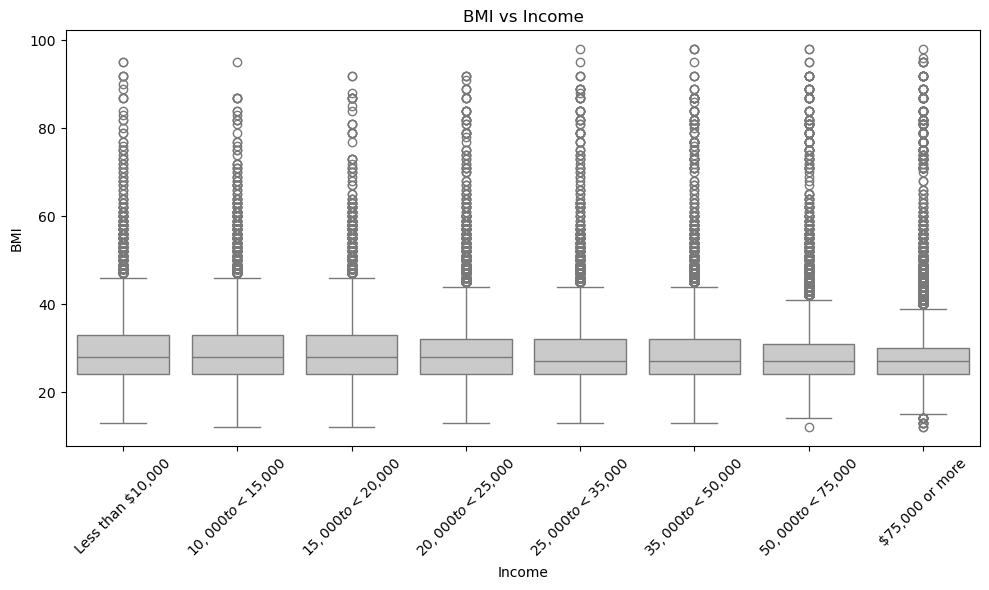

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Income', y='BMI', data=df_trimmed, hue='Income', palette=['#CACACA'])
plt.title('BMI vs Income')
plt.xlabel('Income')
plt.ylabel('BMI')
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)  # Hide the legend
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.savefig('BMI_vs_Income.png')  # Save as PNG file
plt.show()


/var/folders/7l/bq3bbpvd21j2lqtw0s61ff700000gn/T/ipykernel_25306/2159491393.py:2: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Education', y='BMI', data=df_trimmed, hue='Education', palette=['#78909C'])


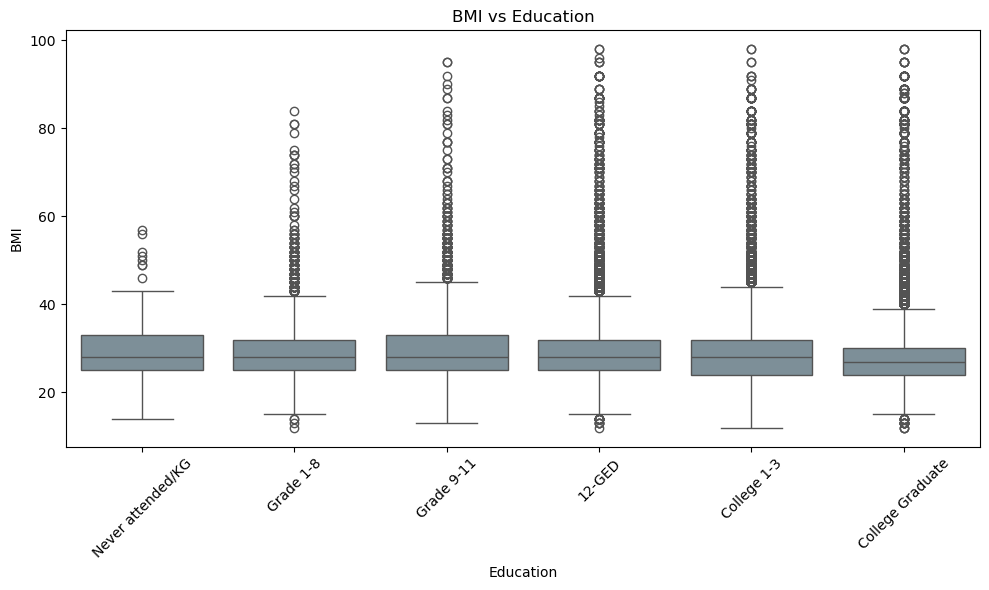

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='BMI', data=df_trimmed, hue='Education', palette=['#78909C'])
plt.title('BMI vs Education')
plt.xlabel('Education')
plt.ylabel('BMI')
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)  # Hide the legend
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.savefig('BMI_vs_Education.png')  # Save as PNG file
plt.show()


/var/folders/7l/bq3bbpvd21j2lqtw0s61ff700000gn/T/ipykernel_25306/428870042.py:2: UserWarning: 
The palette list has fewer values (1) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Age', y='BMI', data=df_trimmed, hue='Age', palette=['#616161'])


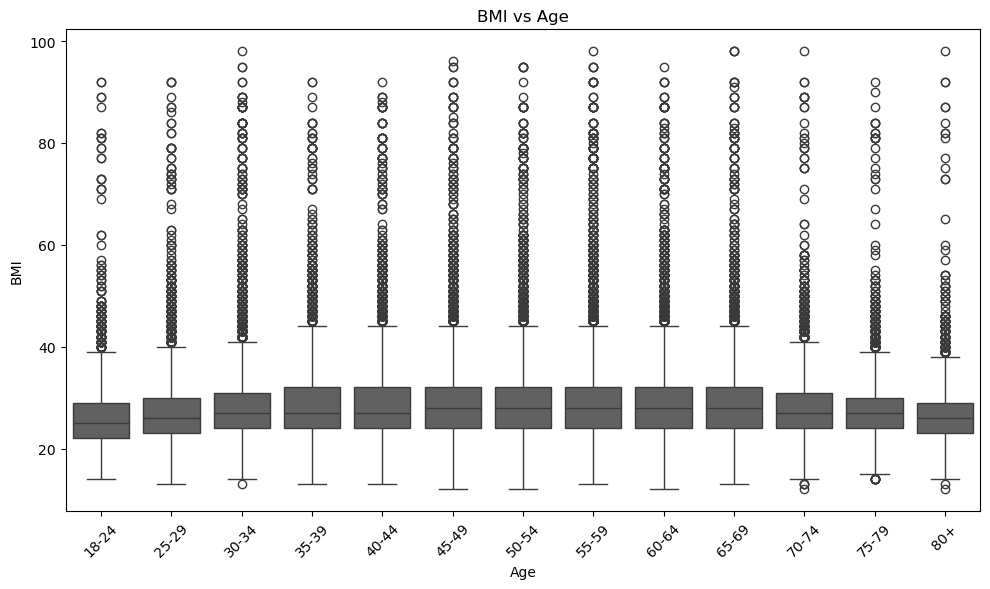

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='BMI', data=df_trimmed, hue='Age', palette=['#616161'])
plt.title('BMI vs Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)  # Hide the legend
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.savefig('BMI_vs_Age.png')  # Save as PNG file
plt.show()


ANOVA Table:
                       sum_sq        df            F  PR(>F)
C(Diabetes_012)  5.612684e+05       2.0  6768.361067     0.0
Residual         1.051812e+07  253677.0          NaN     NaN
Tukey's HSD Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    1.0   2.9819   0.0 2.7578 3.2061   True
   0.0    2.0   4.2015   0.0 4.1148 4.2881   True
   1.0    2.0   1.2195   0.0 0.9837 1.4554   True
-------------------------------------------------


/var/folders/7l/bq3bbpvd21j2lqtw0s61ff700000gn/T/ipykernel_25306/4105470184.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


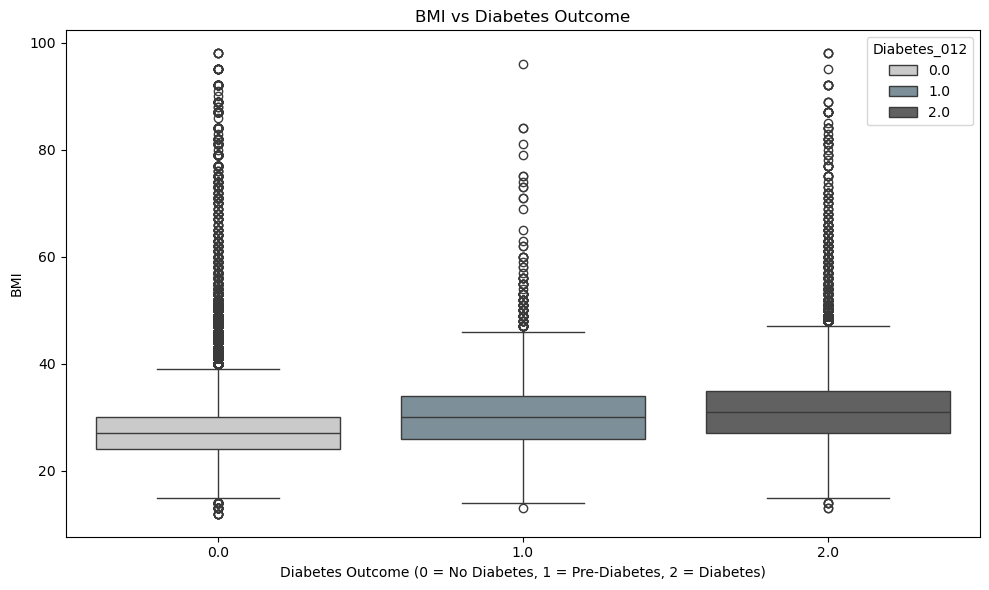

In [44]:
# Load the relevant dataset
file_path = '/Users/muadrashid/Downloads/archive-6/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(file_path)

# Perform ANOVA
anova_model = ols('BMI ~ C(Diabetes_012)', data=data).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("ANOVA Table:")
print(anova_table)

# Check if ANOVA is significant (p < 0.05), then perform Tukey's HSD
if anova_table['PR(>F)'][0] < 0.05:
    tukey = mc.pairwise_tukeyhsd(data['BMI'], data['Diabetes_012'], alpha=0.05)
    print("Tukey's HSD Test:")
    print(tukey)

# Visualization of BMI vs Diabetes Outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='Diabetes_012', y='BMI', data=data, hue='Diabetes_012', palette=['#CACACA','#78909C','#616161'])
plt.title('BMI vs Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0 = No Diabetes, 1 = Pre-Diabetes, 2 = Diabetes)')
plt.ylabel('BMI')
plt.tight_layout()
plt.savefig('BMI_vs_Diabetes_Outcome.png')
plt.show()

## Sophia

In [ ]:
diabetes_df.columns

In [ ]:
# Trim the dataframe so it is only our variables of interest
df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()
df_trimmed.head()

In [ ]:
# Group by heavy alcohol consumption and diabetes status, count the number of participants for each category
alcohol_vs_diabetes = df_trimmed.groupby(["HvyAlcoholConsump", "Diabetes_012"]).size().reset_index(name='count')
alcohol_vs_diabetes
# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
no_alc = alcohol_vs_diabetes[alcohol_vs_diabetes["HvyAlcoholConsump"] == 0].copy()
yes_alc = alcohol_vs_diabetes[alcohol_vs_diabetes["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (fruit and no fruit)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_sum = no_alc["count"].sum()
no_alc["proportion"] = (no_alc["count"] / no_alc_sum) * 100

yes_alc_sum = yes_alc["count"].sum()
yes_alc["proportion"] = (yes_alc["count"] / yes_alc_sum) * 100

# Using the pd.concat() function, combine the two tables into the new fruitstack df, which shows the proportions
alcoholstack = pd.concat([no_alc, yes_alc], ignore_index=False)
alcoholstack



In [ ]:
# Set up pivot table to reorganize fruitstack df
alc_pivot_df =alcoholstack.pivot(index='HvyAlcoholConsump', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
alc_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']


# Rename indices for easy display formatting
index_mapping = {0.0: 'Non heavy alcohol consumption', 1.0: 'Heavy alcohol consumption'}
alc_pivot_df.index = alc_pivot_df.index.map(index_mapping)

# Plot the table
alc_pivot_df.plot(kind='bar', figsize=(10, 6), color = ['#cacaca', '#616161', '#78909c'])
plt.title('Proportion of Respondents with Diabetes\n(Heavy Alcohol Consumption vs Non-heavy Consumption)')
plt.xlabel('Heavy Alcohol Consumption')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=range(len(alc_pivot_df.index)), labels=alc_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/diabetes_vs_alc.png")
plt.show()



In [ ]:
# Running chi squared test
chi2, p, dof, expected = stats.chi2_contingency(alc_pivot_df)

print(f"Chi-squared statistics: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies")
print(expected)
if p>.05:
    print(f"The p-value of the chi-squared test is {round(p,4)}. This value is greater than .05 so it is a null hypothesis\
 and not statistically significant")
else:
    print(f"The p-value of the chi-squared test is {round(p,4)}. This value is less than .05, making it an alternative hypthesis\
    and statistically significant")

In [ ]:
# Group by heavy alcohol consumption and income status, count the number of participants for each category
alcohol_vs_diabetes_income = df_trimmed.groupby(["HvyAlcoholConsump", "Income"]).size().reset_index(name='count')
alcohol_vs_diabetes_income
# Separate 0 heavy alcohol consumption values from 1 heavy alcohol consumption values, copying the tables so we can easily perform actions on them
no_alc_income = alcohol_vs_diabetes_income[alcohol_vs_diabetes_income["HvyAlcoholConsump"] == 0].copy()
yes_alc_income = alcohol_vs_diabetes_income[alcohol_vs_diabetes_income["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (heavy alcohol consumption vs non heavy alcohol consumption)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_sum_income = no_alc_income["count"].sum()
no_alc_income["proportion"] = (no_alc_income["count"] / no_alc_sum_income) * 100

yes_alc_sum_income = yes_alc_income["count"].sum()
yes_alc_income["proportion"] = (yes_alc_income["count"] / yes_alc_sum_income) * 100

# Using the pd.concat() function, combine the two tables into the new df, which shows the proportions
alcoholstack_income = pd.concat([no_alc_income, yes_alc_income], ignore_index=False)
alcoholstack_income



In [ ]:
alcoholstack_income = alcoholstack_income.pivot(index='Income', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for clarity
alcoholstack_income.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
alcoholstack_income.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# Formatting
plt.title('Proportion by Annual Income Level and Heavy Alcohol Consumption')
plt.xlabel('Income Level')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['Less than $10k', 'Less than $15k', 'Less than $20k', 'Less than $25k', 'Less than $35k', 'Less than $50k', 'Less than $75k', 'More than $75k'], rotation=45)
plt.legend(title='Heavy Alcohol Consumption Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
#Heavy Alcohol Consumption and Age

alcohol_vs_diabetes_age = df_trimmed.groupby(["HvyAlcoholConsump", "Age"]).size().reset_index(name='count')
alcohol_vs_diabetes_age

# Separate 0 Heavy Alcohol Consumption values from 1 Heavy Alcohol Consumption values
no_alc_age = alcohol_vs_diabetes_age[alcohol_vs_diabetes_age["HvyAlcoholConsump"] == 0].copy()
yes_alc_age = alcohol_vs_diabetes_age[alcohol_vs_diabetes_age["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (Heavy Alcohol Consumption and no Heavy Alcohol Consumption)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_sum_age = no_alc_age["count"].sum()
no_alc_age["proportion"] = (no_alc_age["count"] / no_alc_sum_age) * 100

yes_alc_sum_age = yes_alc_age["count"].sum()
yes_alc_age["proportion"] = (yes_alc_age["count"] / yes_alc_sum_age) * 100

# Using the pd.concat() function, combine the two tables into the new Heavy Alcohol Consumption df
alcoholstack_age = pd.concat([no_alc_age, yes_alc_age], ignore_index=False)
alcoholstack_age

In [ ]:
alcoholstack_age = alcoholstack_age.pivot(index='Age', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for clarity
alcoholstack_age.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
alcoholstack_age.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# Formatting
plt.title('Proportion by Age and Heavy Alcohol Consumption')
plt.xlabel('Age')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+' ], rotation=45)
plt.legend(title='Heavy Alcohol Consumption Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
#Heavy Alcohol Consumption to Education
alcohol_vs_diabetes_edu = df_trimmed.groupby(["HvyAlcoholConsump", "Education"]).size().reset_index(name='count')


# Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
no_alc_edu = alcohol_vs_diabetes_edu[alcohol_vs_diabetes_edu["HvyAlcoholConsump"] == 0].copy()
yes_alc_edu = alcohol_vs_diabetes_edu[alcohol_vs_diabetes_edu["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (PhysActivity and no PhysActivity)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_edu_sum = no_alc_edu["count"].sum()
no_alc_edu["proportion"] = (no_alc_edu["count"] / no_alc_edu_sum) * 100

yes_alc_edu_sum = yes_alc_edu["count"].sum()
yes_alc_edu["proportion"] = (yes_alc_edu["count"] / yes_alc_edu_sum) * 100

# Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
alcoholstack_edu = pd.concat([no_alc_edu, yes_alc_edu], ignore_index=False)
alcoholstack_edu

In [ ]:
alcoholstack_edu = alcoholstack_edu.pivot(index='Education', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for clarity
alcoholstack_edu.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
alcoholstack_edu.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# Formatting
plt.title('Proportion by Education and Heavy Alcohol Consumption')
plt.xlabel('Education')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['No School', 'Elementary', 'Some High School', 'High School Graduate', 'Some College or Technical School', 'College Graduate'], rotation=45)
plt.legend(title='Heavy Alcohol Consumption Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Group by income and Heavy Alcohol Consumption, count the number of responses in each row
income_alc = df_trimmed.groupby(['Income', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each income group
income_alc_group_sum = income_alc.groupby('Income')['count'].transform('sum')

# Calculate the proportions
income_alc['proportion'] = (income_alc['count'] / income_alc_group_sum) * 100

# Pivot the table
income_alc_pivot_df = income_alc.pivot(index='Income', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
income_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }

income_alc_pivot_df.index = income_alc_pivot_df.index.map(index_mapping)

# Plot the table
ax = income_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'] )
plt.title('Heavy Alcohol Consumption by Income Group')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(income_alc_pivot_df.index)), labels=income_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/income_vs_alc.png")
plt.show()



In [ ]:
# Group by education and heavy alcohol consumption, count the number of responses in each row
edu_alc = df_trimmed.groupby(['Education', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
edu_alc_group_sum = edu_alc.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_alc['proportion'] = (edu_alc['count'] / edu_alc_group_sum) * 100

# Pivot the table
edu_alc_pivot_df = edu_alc.pivot(index='Education', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
edu_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

edu_alc_pivot_df.index = edu_alc_pivot_df.index.map(index_mapping)

# Plot the table
ax = edu_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'])
plt.title('Heavy Alcohol Consumption by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(edu_alc_pivot_df.index)), labels=edu_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/edu_vs_alc.png")
plt.show()

In [ ]:
# Group by age and fruits, count the number of responses in each row
age_alc = df_trimmed.groupby(['Age', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each age group
age_alc_group_sum = age_alc.groupby('Age')['count'].transform('sum')

# Calculate the proportions
age_alc['proportion'] = (age_alc['count'] / age_alc_group_sum) * 100

# Pivot the table
age_alc_pivot_df = age_alc.pivot(index='Age', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
age_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

age_alc_pivot_df.index = age_alc_pivot_df.index.map(index_mapping)

# Plot the table
ax = age_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'])
plt.title('Heavy Alcohol Consumption by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(age_alc_pivot_df.index)), labels=age_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/age_vs_alc.png")
plt.show()


## Conclusions and Bonus Workspace